In [2]:
import random
from functools import partial

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import CenterCrop
import os
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
import time




In [3]:
# read data from ./CrackDataset_DL_HY/SematicSeg_Dataset
DATASET_PATH = os.path.join(os.getcwd(), 'concreteCrackSegmentationDataset')
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, 'rgb')
MASK_DATASET_PATH = os.path.join(DATASET_PATH, 'BW')
    
# define the test split
TEST_SPLIT = 0.15

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 3
NUM_CLASSES = 1
NUM_LEVELS = 3

# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 5
BATCH_SIZE = 4
# define the input image dimensions
INPUT_IMAGE_WIDTH = 1280
INPUT_IMAGE_HEIGHT = 960

# define threshold to filter weak predictions
THRESHOLD = 0.5

# define the path to the base output directory
BASE_OUTPUT = os.path.join(os.getcwd(), 'output')

# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [4]:
import os.path
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
class SegmentationDataSet(Dataset):
    def __init__(self,rootdir,labeldir,img_name_ls, transform=None):
        self.data_dir=rootdir
        self.label_dir=labeldir
        self.img_name_ls = img_name_ls
        self.data_len = len(img_name_ls)
        self.transform = transform
    
    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        image_path=os.path.join(self.data_dir,self.img_name_ls[index])
        label_path = os.path.join(self.label_dir,self.img_name_ls[index])
        img=Image.open(image_path)
        img = np.array(img)
        img_label=Image.open(label_path).convert('L')
        img_label = np.array(img_label)
        if self.transform:
            img = self.transform(img)
            img_label = self.transform(img_label)
        return img, img_label

In [5]:
# U-Net model
class Block(nn.Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = nn.Conv2d(inChannels, outChannels, 3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(outChannels, outChannels, 3)
    
    def forward(self, x):
        # apply the convolution and RELU layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x

class Encoder(nn.Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = nn.ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        # return the list containing the intermediate outputs
        return blockOutputs

class Decoder(nn.Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2) for i in range(len(channels) - 1)])
        self.dec_blocks = nn.ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
        
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        # return the final decoder output
        return x
    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures

class UNet(nn.Module):
    def __init__(self, encChannels=(3, 16, 32, 64),
		 decChannels=(64, 32, 16),
		 nbClasses=1, retainDim=True,
		 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        # initialize the regression head and store the class variables
        self.head = nn.Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0],
            encFeatures[::-1][1:])
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        # return the segmentation map
        return map

In [6]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(os.listdir(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(os.listdir(MASK_DATASET_PATH)))

# only use first 10 pictures
imagePaths = imagePaths[:50]
maskPaths = maskPaths[:50]

for file_name in imagePaths:
    os.rename(os.path.join(IMAGE_DATASET_PATH,file_name),os.path.join(IMAGE_DATASET_PATH,file_name.lower()))

# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
	test_size=TEST_SPLIT, random_state=42)

# unpack the training and testing image and mask paths
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [7]:
# define transformations
transform = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((INPUT_IMAGE_HEIGHT,
		INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataSet(IMAGE_DATASET_PATH, MASK_DATASET_PATH,trainImages,transform=transform)
testDS = SegmentationDataSet(IMAGE_DATASET_PATH, MASK_DATASET_PATH, testImages,transform=transform)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY)
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY)

[INFO] found 42 examples in the training set...
[INFO] found 8 examples in the test set...


In [8]:
# initialize our UNet model
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [9]:
#evalution metric with mIoU

class SegmentationMetric(object):
    def __init__(self, numClass):
        self.numClass = numClass
        self.confusionMatrix = np.zeros((self.numClass,)*2)


    def meanIntersectionOverUnion(self):
        # Intersection = TP Union = TP + FP + FN
        # IoU = TP / (TP + FP + FN)
        intersection = np.diag(self.confusionMatrix)
        union = np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) - np.diag(self.confusionMatrix)
        IoU = intersection / union
        mIoU = np.nanmean(IoU)
        return mIoU

    def genConfusionMatrix(self, imgPredict, imgLabel):
        # remove classes from unlabeled pixels in gt image and predict
        imgPredict = torch.sigmoid(imgPredict)
        imgPredict = torch.where(imgPredict>=0.5,1,0)
        mask = (imgLabel >= 0) & (imgLabel < self.numClass)
        label = self.numClass * imgLabel[mask] + imgPredict[mask]
        count = np.bincount(label, minlength=self.numClass**2)
        confusionMatrix = count.reshape(self.numClass, self.numClass)
        return confusionMatrix

    def addBatch(self, imgPredict, imgLabel):
        assert imgPredict.shape == imgLabel.shape
        self.confusionMatrix += self.genConfusionMatrix(imgPredict.cpu(), imgLabel.cpu())



In [11]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	mIOU = 0
	# loop over the training set
	for (i, (x, y)) in tqdm(enumerate(trainLoader)):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
			#evalution metric
			metric = SegmentationMetric(2)
			metric.addBatch(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	avgmIOU = metric.meanIntersectionOverUnion()
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f},mIOU:{:.2f}".format(
		avgTrainLoss, avgTestLoss, avgmIOU))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


11it [00:43,  3.99s/it]0:00<?, ?it/s]
 20%|██        | 1/5 [00:51<03:24, 51.04s/it]

[INFO] EPOCH: 1/5
Train loss: 0.063892, Test loss: 0.0603,mIOU:0.49


11it [00:27,  2.53s/it]
 40%|████      | 2/5 [01:37<02:24, 48.20s/it]

[INFO] EPOCH: 2/5
Train loss: 0.061331, Test loss: 0.0572,mIOU:0.49


11it [00:37,  3.45s/it]
 60%|██████    | 3/5 [02:19<01:31, 45.60s/it]

[INFO] EPOCH: 3/5
Train loss: 0.059479, Test loss: 0.0571,mIOU:0.49


11it [00:48,  4.44s/it]
 80%|████████  | 4/5 [03:13<00:48, 48.69s/it]

[INFO] EPOCH: 4/5
Train loss: 0.058945, Test loss: 0.0574,mIOU:0.49


11it [00:26,  2.40s/it]
100%|██████████| 5/5 [03:44<00:00, 44.89s/it]

[INFO] EPOCH: 5/5
Train loss: 0.057258, Test loss: 0.0563,mIOU:0.49
[INFO] total time taken to train the model: 224.44s


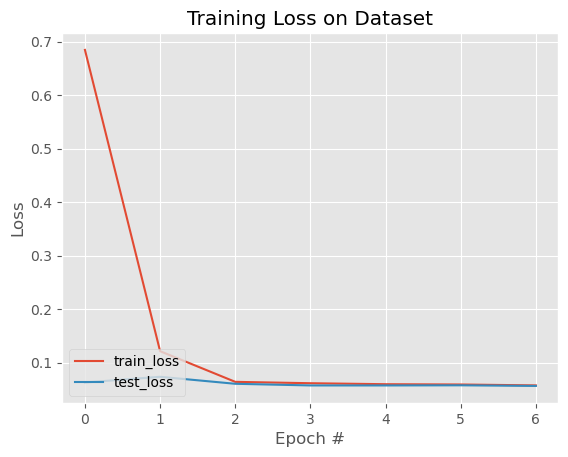

In [18]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

In [19]:
# USAGE
# python predict.py
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

[INFO] loading up test image paths...
['043.jpg']
[INFO] load up model...


C:\Users\zheng\AppData\Local\Temp\ipykernel_9512\570198200.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


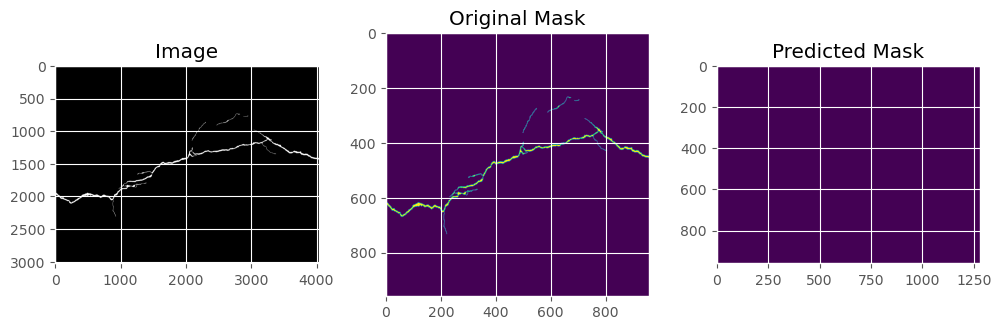

In [26]:
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(MASK_DATASET_PATH,
			filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT,
			INPUT_IMAGE_HEIGHT))

		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		# filter out the weak predictions and convert them to integers
		predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)
		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=1)
print(imagePaths)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	path1 = os.path.join(MASK_DATASET_PATH, path)
	make_predictions(unet, path1)